In [4]:
import gc

import matplotlib.pyplot as plt
import torch
from fontTools.misc.cython import returns
from tqdm.notebook import tqdm
from sklearn.decomposition import PCA

from torch.func import jacrev, jacfwd, vmap
from torch.distributions import MultivariateNormal

from stochman.manifold import EmbeddedManifold
from stochman.geodesic import geodesic_minimizing_energy
from stochman import CubicSpline

from circular_utils import *
from plot_utils import *

In [5]:
# Parameters
num_points = 300
r_inner = 0.7  # Inner radius (hole radius)
r_outer = 1.0  # Outer radius

In [6]:
# Generate points
data = generate_annular_points(num_points, r_inner, r_outer)
#data_3d = generate_annular_points_3d(num_points, r_inner, r_outer)
grid_size = 100
z_grid, x_lin, y_lin = generate_grid(grid_size=grid_size, device='cpu')

In [7]:
#simple_2d_plot(data, num_points)

In [8]:
dm = DensityMetric(data, 0.1)
real_bg = dm.density(z_grid.reshape(-1, 2)).reshape((grid_size, grid_size))

In [9]:
num_curves = 30
N, D = data.shape
curve_indices = torch.randint(data.shape[0], (num_curves, 2))  # (num_curves) x 2

In [10]:
batch_c = CubicSpline(begin=data[curve_indices[:, 0]], end=data[curve_indices[:, 1]], num_nodes=20)
geodesic_minimizing_energy(curve=batch_c, manifold=dm, optimizer=torch.optim.RMSprop, max_iter=250)

tensor(False)

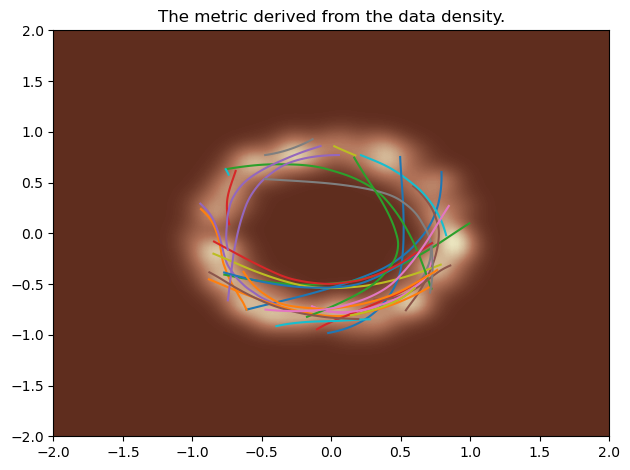

In [11]:
plt.scatter(data[:, 0], data[:, 1], s=1, alpha=0.5)
plt.contourf(x_lin, y_lin, real_bg, levels=100, cmap=rbrown_yellow_cmap)  # Use the custom brownish colormap
batch_c.plot()
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.title("The metric derived from the data density.")
plt.tight_layout()
plt.show()

In [12]:
batch_c.euclidean_length().mean().item()

1.2955702543258667

In [13]:
data_vae = embed_points_2d_to_higher_dim(data, n_dim=100)
data_vae.shape, data_vae.max(), data_vae.min()

((300, 100), 0.99374914, -0.98385096)

In [14]:
train_loader = torch.utils.data.DataLoader(DumbDataset(z=data,y=data_vae), batch_size=64, shuffle=True)
data_vae.shape, data_vae.max(), data_vae.min()

((300, 100), 0.99374914, -0.98385096)

In [15]:
# normalize the data_vae and compute PCA
n_data_vae = (data_vae - data_vae.mean(axis=0)) / data_vae.std(axis=0)
data_vae_3d = PCA(n_components=3).fit_transform(n_data_vae)
# normalize the data_vae_3d
data_vae_3d = (data_vae_3d - data_vae_3d.mean(axis=0)) / data_vae_3d.std(axis=0)

In [16]:
#simple_3d_plot(data_vae_3d, num_points)
#interactive_3d_plot(data_vae_3d, num_points)

In [17]:
model = get_decoder()
model.train();

In [18]:
epochs = 50
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [19]:
# write a training loop with tqdm
model.to(device)
losses = []
for epoch in tqdm(range(epochs)):
    for batch in train_loader:
        z, y = batch
        z = z.to(device)
        opt.zero_grad()
        y_hat = model(z)
        loss = torch.nn.functional.mse_loss(y_hat, y.to(device))
        losses.append(loss.item())
        loss.backward()
        opt.step()

  0%|          | 0/50 [00:00<?, ?it/s]

In [20]:
## Put trained models in 'eval' mode
model.eval();
model.to('cpu');

In [21]:
gc.collect()

5787

In [22]:
class DecoderInducedManifold(EmbeddedManifold):
    def __init__(self, decoder, input_dim=2):
        self.decoder = decoder
        self.input_dim = input_dim
    def embed(self, c, jacobian=False):
        reshaped = False
        if c.dim() == 3:
            B, N, D = c.shape
            c = c.reshape(-1, self.input_dim)
            reshaped = True
        out = self.decoder(c)
        out = out.reshape(B, N, -1) if reshaped else out
        if jacobian:
            return out, vmap(jacfwd(self.decoder))(c)
            # TO_CHECK: it is strange that jacfwd is faster than jacrev
        else:
            return out

In [23]:
M = DecoderInducedManifold(model)
z_grid_list = z_grid.reshape(-1, 2)
vol_by_dec = M.volume(z_grid_list).detach().numpy().reshape((grid_size, grid_size))
c, _ = M.connecting_geodesic(p0=data[curve_indices[:, 0]], p1=data[curve_indices[:, 1]])

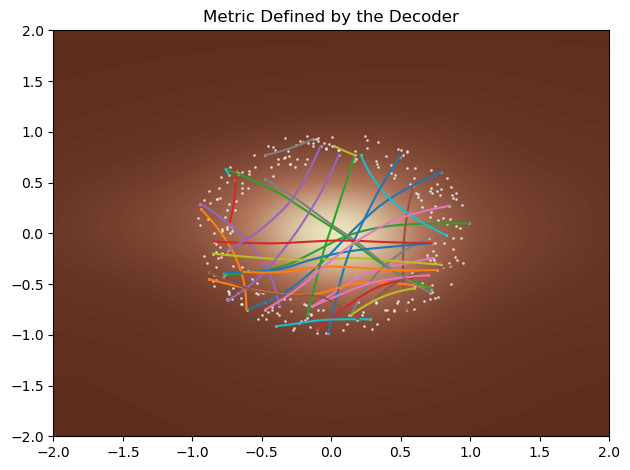

In [24]:
# Plot the magnification factor
plt.figure()
plt.contourf(x_lin, y_lin, vol_by_dec, levels=100, cmap=rbrown_yellow_cmap)  # Use the custom brownish colormap
plt.scatter(data[:, 0].cpu().numpy(), data[:, 1].cpu().numpy(), s=1, alpha=0.6,c='w')
c.plot()
plt.title("Metric Defined by the Decoder")
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.tight_layout()
plt.show()

In [25]:
device = 'cpu'
double_model = DoubleDecoder(device=device)
double_model.train();
d_opt = torch.optim.Adam(double_model.parameters(), lr=1e-3)

In [26]:
double_model.to(device)
losses = []
sigmas = []
for epoch in tqdm(range(epochs)):
    for batch in train_loader:
        z, y = batch
        z = z.to(device)
        d_opt.zero_grad()
        y_hat, _sigma = double_model(z, randomness=True, return_sigma=True)
        loss = torch.nn.functional.mse_loss(y_hat, y.to(device))
        losses.append(loss.item())
        sigmas.append(_sigma.detach().mean().item())
        loss.backward()
        d_opt.step()

  0%|          | 0/50 [00:00<?, ?it/s]

In [27]:
# plot the sigmas
#plt.plot(sigmas)

In [28]:
double_model.eval();
with torch.no_grad():
    _, _sigma = double_model(z_grid_list, return_sigma=True)
    _sigma = _sigma.cpu().detach().numpy().mean(axis=1).reshape((grid_size, grid_size))
_sigma.shape

(100, 100)

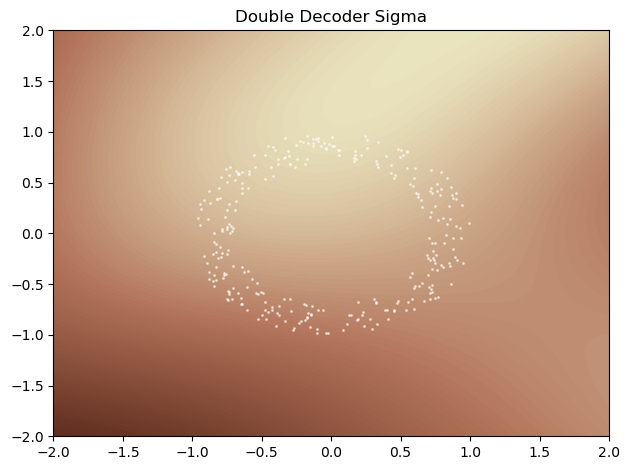

In [29]:
plt.figure()
plt.contourf(x_lin, y_lin, _sigma, levels=100, cmap=rbrown_yellow_cmap_inv)  # Use the custom brownish colormap
plt.scatter(data[:, 0].cpu().numpy(), data[:, 1].cpu().numpy(), s=1, alpha=0.6,c='w')
plt.title("Double Decoder Sigma")
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.tight_layout()
plt.show()

In [30]:
double_model.to('cpu')
ddM = DoubleDecoderInducedManifold(double_model)
vol_by_dd = ddM.volume(z_grid_list.cpu()).detach().numpy().reshape((grid_size, grid_size))
dd_c, _ = ddM.connecting_geodesic(p0=data[curve_indices[:, 0]], p1=data[curve_indices[:, 1]])

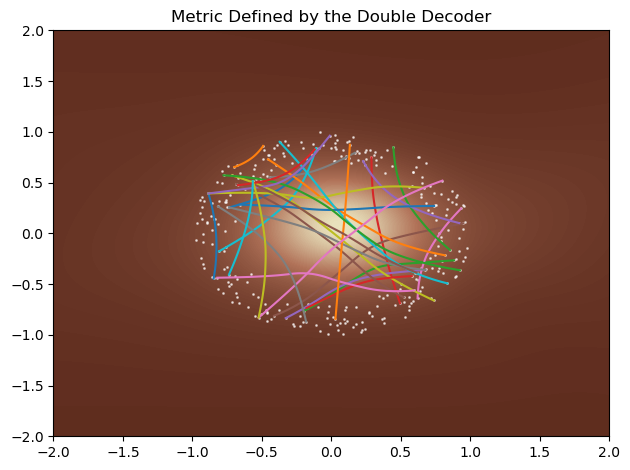

In [40]:
plt.figure()
plt.contourf(x_lin, y_lin, vol_by_dd, levels=100, cmap=rbrown_yellow_cmap)  # Use the custom brownish colormap
plt.scatter(data[:, 0].cpu().numpy(), data[:, 1].cpu().numpy(), s=1, alpha=0.6,c='w')
dd_c.plot()
plt.title("Metric Defined by the Double Decoder")
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.tight_layout()
plt.show()